In [1]:
#A bit hacky but we aren't planning on using keras on GPU so we disable warnings 
#(otherwise Jupyter crashes)
import os 
os.environ['HDF5_DISABLE_VERSION_CHECK']='1'

from Preprocessor import Preprocessor

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from pathlib import *
import pandas as pd

import matplotlib.pyplot as plt

C:\Users\Andres\Anaconda3\lib\site-packages\h5py\__init__.py:40: UserWarning: h5py is running against HDF5 1.10.5 when it was built against 1.10.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
#Import test data - this is the FB messages I have tagged
path_to_test = Path("..") / "data" / "processed" / "tagged_data.xlsx"
test_df = pd.read_excel(path_to_test)
test_df.dropna(axis=0, inplace = True)
test_df.reset_index(drop = True, inplace = True)

In [3]:
#Make the test_df ratings range from -1 to 1
def adjustRange(rating):
    if rating < 3:
        return -1
    elif rating == 3:
        return 0
    else:
        return 1

test_df["Rating"] = [adjustRange(x) for x in test_df["1 to 5"]]

In [4]:
#Import train data - this is the reddit + twitter posts
path_to_train = Path("..") / "data" / "training" / "training_combined.csv"
train_df = pd.read_csv(path_to_train)
train_df.dropna(axis=0, inplace = True)

In [5]:
preprocessor = Preprocessor()
#Preprocess data
train_df["Preprocessed"] = [preprocessor.preprocess_text(x) for x in train_df["Text"]]
test_df["Preprocessed"] = [preprocessor.preprocess_text(x) for x in test_df["Message"]]

In [6]:
#Initialise tokenizer, this will be used to produce bag of words etc
BoW = Tokenizer()
BoW.fit_on_texts(train_df["Preprocessed"])

#Text2seq
train_df["Seq"] = BoW.texts_to_sequences(train_df["Preprocessed"])
X_train = train_df["Seq"]
y_train = train_df["Rating"]

test_df["Seq"] = BoW.texts_to_sequences(test_df["Preprocessed"])
X_test = test_df["Seq"]
y_test = test_df["Rating"]

In [7]:
#We want to find the max length of X_train to pad the seq
def FindMaxLength(lst):
    maxList = max(lst, key = lambda i: len(i))
    maxLength = len(maxList)
    return maxLength, maxList

maxLength,_ = FindMaxLength(X_train)
#This turns out to be >800

(array([74073., 72412., 44404.,  5081.,  1184.,   759.,   467.,   317.,
          241.,   225.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

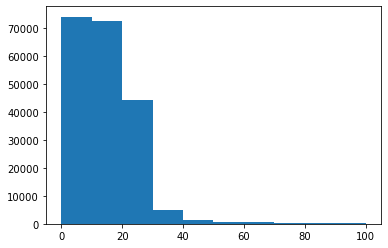

In [8]:
#Let's find the distribution of lengths to make sure we capture most
plt.hist([len(x) for x in X_train], range = (0, 100))

In [9]:
#We can pad ~50/60 and capture most data
pad = 1000
X_train_padded = pad_sequences(X_train, pad)
X_test_padded = pad_sequences(X_test, pad)

In [10]:
#Easiest thing is to just make it 0-2 for the classifier 
y_test = y_test + 1
y_train = y_train + 1

### We have the training data ready
# Now we initialise the model

In [11]:
#Initialise model
model = Sequential()

In [12]:
#Set layers
model.add(Embedding(len(BoW.index_word)+1, 32))
model.add(LSTM(32, dropout = 0.1, recurrent_dropout = 0))
model.add(Dense(32, activation = "relu"))
model.add(Dense(3, activation = "sigmoid"))

In [13]:
#Compile - set parameters ie loss
model.compile(optimizer = "adam",
             loss = "SparseCategoricalCrossentropy",
             metrics = ["acc"])


In [14]:
#Set parameters for training - early stopping
early_stopping = EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [15]:
#Train Model
history = model.fit(X_train_padded, y_train,
                   batch_size = 500, epochs = 10,
                   validation_data = (X_test_padded, y_test),
                   callbacks = [early_stopping])

Epoch 1/10
401/401 [==============================] - 1704s 4s/step - loss: 0.8403 - acc: 0.6001 - val_loss: 1.5976 - val_acc: 0.4836
Epoch 2/10
401/401 [==============================] - 1810s 5s/step - loss: 0.3663 - acc: 0.8723 - val_loss: 1.8131 - val_acc: 0.4952
Epoch 3/10
401/401 [==============================] - 1886s 5s/step - loss: 0.3079 - acc: 0.8948 - val_loss: 1.9073 - val_acc: 0.4971
Epoch 4/10
401/401 [==============================] - 4682s 12s/step - loss: 0.2764 - acc: 0.9067 - val_loss: 2.0586 - val_acc: 0.4932
Epoch 5/10
401/401 [==============================] - 1822s 5s/step - loss: 0.2554 - acc: 0.9145 - val_loss: 2.0147 - val_acc: 0.4990
Epoch 6/10
401/401 [==============================] - 43903s 110s/step - loss: 0.2353 - acc: 0.9215 - val_loss: 2.1033 - val_acc: 0.5029
Epoch 7/10
401/401 [==============================] - 1849s 5s/step - loss: 0.2228 - acc: 0.9262 - val_loss: 2.2775 - val_acc: 0.4990
Epoch 8/10
401/401 [==============================] - 1841

# Test out on some more of the data from FB

In [191]:
path_fb = Path("..") / "data" / "processed" / "tagged_data.xlsx"
fb_df = pd.read_excel(path_fb)

In [192]:
fb_df["Preprocessed"] = [preprocessor.preprocess_text(x) for x in fb_df["Message"]]

In [194]:
fb_df = fb_df[fb_df.astype(str)["Preprocessed"] != "[]"]

In [98]:
fb_df.reset_index(drop = True, inplace = True)

In [217]:
for i in fb_df[20:30]["rmv_words"]:
    print(i)
    
for i in fb_df[20:30]["Preprocessed"]:
    print(i)

['photo', 'per', 'angl', 'attack', 'angl', 'attack', 'per', 'model']
['see']
['move', 'bike', 'bike', 'storag']
['alright', 'move']
['btw']
['plenti', 'alcohol']
['free', 'alreadi']
['ye']
['anyon', 'still', 'around']
['readi', 'parti']
['photo', 'per', 'angl', 'attack', 'angl', 'attack', 'per', 'model']
['see']
['move', 'bike', 'bike', 'storag']
['alright', 'move']
['btw']
['plenti', 'alcohol']
['free', 'alreadi']
['ye']
['anyon', 'still', 'around']
['readi', 'parti']


In [221]:
#THIS REMOVES WORDS NOT IN VOCAB
fb_df["rmv_words"] = fb_df["Preprocessed"]

for i,x in enumerate(fb_df["rmv_words"]):
    to_rmv = []
    for y in x:
        if y not in BoW.word_index:
            to_rmv.append(y)
            print(to_rmv)
    [x.remove(z) for z in to_rmv]

C:\Users\Andres\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [233]:
fb_df["Seq"] = BoW.texts_to_sequences(fb_df["rmv_words"])

C:\Users\Andres\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [240]:
fb_df = fb_df[fb_df.astype(str)["Seq"] != "[]"]

In [308]:
test_sentiment = fb_df
test_sentiment["Sentiment"]= [sum(model.predict(x)) for x in test_sentiment["Seq"]]

C:\Users\Andres\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [309]:
test_sentiment

,Title,IsGroup,StillPart,NumParticipants,Participants,Sender,Message,DateTime,type,Preprocessed,rmv_words,Seq,Sentiment
0,10 degrees? Dangerous?,RegularGroup,True,4,"Andres Altena,James Roberts,Jamie Blaiklock,Fr...",Andres Altena,Also we should include a picture with low angl...,2018-01-26 11:57:56.936,Generic,"[also, includ, pictur, low, angl, attack, ment...","[also, includ, pictur, low, angl, attack, ment...","[28, 466, 728, 394, 2874, 159, 517, 38, 301, 2...","[6.1277833, 5.322806, 7.1650085]"
1,10 degrees? Dangerous?,RegularGroup,True,4,"Andres Altena,James Roberts,Jamie Blaiklock,Fr...",Andres Altena,Just as a rough guide,2018-01-26 11:57:15.024,Generic,"[rough, guid]","[rough, guid]","[5107, 2126]","[1.2971472, 0.715618, 0.80195826]"
2,10 degrees? Dangerous?,RegularGroup,True,4,"Andres Altena,James Roberts,Jamie Blaiklock,Fr...",Andres Altena,Then control surfaces done by the last 2,2018-01-26 11:56:59.399,Generic,"[control, surfac, done, last]","[control, surfac, done, last]","[574, 3819, 55, 92]","[1.8474853, 1.6120808, 2.2756252]"
3,10 degrees? Dangerous?,RegularGroup,True,4,"Andres Altena,James Roberts,Jamie Blaiklock,Fr...",Andres Altena,Then second person talks about Yaw and varying...,2018-01-26 11:56:49.269,Generic,"[second, person, talk, vari, aspect, ratio]","[second, person, talk, vari, aspect, ratio]","[455, 91, 89, 5133, 2278, 4413]","[2.783485, 2.7416964, 3.165492]"
4,10 degrees? Dangerous?,RegularGroup,True,4,"Andres Altena,James Roberts,Jamie Blaiklock,Fr...",Andres Altena,And that could be 4-5 mind,2018-01-26 11:56:23.191,Generic,"[could, mind]","[could, mind]","[130, 286]","[0.9395639, 0.8089883, 1.1224852]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56649,Zakir Khokher,Regular,True,2,"Zakir Khokher,Andres Altena",Andres Altena,hey mate,2016-09-27 14:02:50.449,Generic,"[hey, mate]","[hey, mate]","[887, 3245]","[0.64974374, 1.0838206, 1.1814047]"
56650,Zakir Khokher,Regular,True,2,"Zakir Khokher,Andres Altena",Andres Altena,Ill be there in 5 mins,2015-10-08 19:20:55.878,Generic,"[ill, min]","[ill, min]","[1168, 1548]","[1.3447652, 0.6000836, 0.85491526]"
56651,Zesty,RegularGroup,True,21,"Abdulla Qmsz,Shail Desai,Andres Altena,James R...",Andres Altena,This still happening in the bar?,2018-04-18 20:53:57.526,Generic,"[still, happen, bar]","[still, happen, bar]","[87, 85, 900]","[1.3911494, 1.3331127, 1.6195735]"
56652,Zornitsa Zheleva,Regular,True,2,"Zornitsa Zheleva,Andres Altena",Andres Altena,What happened there?,2017-09-02 11:55:13.632,Generic,[happen],[happen],[85],"[0.45174065, 0.4450248, 0.5520072]"


In [310]:
import numpy

In [311]:
def test_conclude(scores):
    if abs(1 - scores[0]/(scores[2] + 0.0000001)) < 0.2:
        return 1
    else:
        return numpy.argmax(scores)

In [312]:
def translate(num):
    if num == 0:
        return "Negative"
    elif num == 1:
        return "Neutral"
    elif num == 2:
        return "Positive"
    else:
        return "This shouldn't happen"

In [313]:
test_sentiment["Test_conclude"] = [test_conclude(x) for x in test_sentiment["Sentiment"]]

C:\Users\Andres\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [314]:
test_sentiment["Results"] = [translate(x) for x in test_sentiment["Test_conclude"]]

C:\Users\Andres\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [315]:
BoW.texts_to_sequences(["great"])

[[90]]

In [316]:
model.predict([90])

array([[0.18348533, 0.19420812, 0.8883363 ]], dtype=float32)

In [317]:
test_sentiment

,Title,IsGroup,StillPart,NumParticipants,Participants,Sender,Message,DateTime,type,Preprocessed,rmv_words,Seq,Sentiment,Test_conclude,Results
0,10 degrees? Dangerous?,RegularGroup,True,4,"Andres Altena,James Roberts,Jamie Blaiklock,Fr...",Andres Altena,Also we should include a picture with low angl...,2018-01-26 11:57:56.936,Generic,"[also, includ, pictur, low, angl, attack, ment...","[also, includ, pictur, low, angl, attack, ment...","[28, 466, 728, 394, 2874, 159, 517, 38, 301, 2...","[6.1277833, 5.322806, 7.1650085]",1,Neutral
1,10 degrees? Dangerous?,RegularGroup,True,4,"Andres Altena,James Roberts,Jamie Blaiklock,Fr...",Andres Altena,Just as a rough guide,2018-01-26 11:57:15.024,Generic,"[rough, guid]","[rough, guid]","[5107, 2126]","[1.2971472, 0.715618, 0.80195826]",0,Negative
2,10 degrees? Dangerous?,RegularGroup,True,4,"Andres Altena,James Roberts,Jamie Blaiklock,Fr...",Andres Altena,Then control surfaces done by the last 2,2018-01-26 11:56:59.399,Generic,"[control, surfac, done, last]","[control, surfac, done, last]","[574, 3819, 55, 92]","[1.8474853, 1.6120808, 2.2756252]",1,Neutral
3,10 degrees? Dangerous?,RegularGroup,True,4,"Andres Altena,James Roberts,Jamie Blaiklock,Fr...",Andres Altena,Then second person talks about Yaw and varying...,2018-01-26 11:56:49.269,Generic,"[second, person, talk, vari, aspect, ratio]","[second, person, talk, vari, aspect, ratio]","[455, 91, 89, 5133, 2278, 4413]","[2.783485, 2.7416964, 3.165492]",1,Neutral
4,10 degrees? Dangerous?,RegularGroup,True,4,"Andres Altena,James Roberts,Jamie Blaiklock,Fr...",Andres Altena,And that could be 4-5 mind,2018-01-26 11:56:23.191,Generic,"[could, mind]","[could, mind]","[130, 286]","[0.9395639, 0.8089883, 1.1224852]",1,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56649,Zakir Khokher,Regular,True,2,"Zakir Khokher,Andres Altena",Andres Altena,hey mate,2016-09-27 14:02:50.449,Generic,"[hey, mate]","[hey, mate]","[887, 3245]","[0.64974374, 1.0838206, 1.1814047]",2,Positive
56650,Zakir Khokher,Regular,True,2,"Zakir Khokher,Andres Altena",Andres Altena,Ill be there in 5 mins,2015-10-08 19:20:55.878,Generic,"[ill, min]","[ill, min]","[1168, 1548]","[1.3447652, 0.6000836, 0.85491526]",0,Negative
56651,Zesty,RegularGroup,True,21,"Abdulla Qmsz,Shail Desai,Andres Altena,James R...",Andres Altena,This still happening in the bar?,2018-04-18 20:53:57.526,Generic,"[still, happen, bar]","[still, happen, bar]","[87, 85, 900]","[1.3911494, 1.3331127, 1.6195735]",1,Neutral
56652,Zornitsa Zheleva,Regular,True,2,"Zornitsa Zheleva,Andres Altena",Andres Altena,What happened there?,2017-09-02 11:55:13.632,Generic,[happen],[happen],[85],"[0.45174065, 0.4450248, 0.5520072]",1,Neutral


In [318]:
path_sent = Path("..") / "data" / "processed" / "sentiment.xlsx"
test_sentiment.to_excel(path_sent)